In [1]:
#Imports
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from scipy.stats import qmc
from scipy.io.wavfile import write
import scipy.io
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.optimize import minimize, fsolve, root
from tqdm import tqdm
import os
from time import time
from numba import njit
from scipy.signal import find_peaks

# /!\ Important ! parfois les labels sont inversés (les 1 sont des -1 et inversement, ne pas paniquer, je crois)

# Comment utiliser ce notebook ?

Dans la première section, j'ai rebidouillé les codes des deux modèles. ceux-ci étant très proches, toutes les variables et les fonctions partagent les mêmes noms. Cela fait que si vous voulez cartographier un modèle, runnez la cellule de celui-ci, mais PAS CELLE DE l'AUTRE, sinon les variables vont s'override.

La cellule d'un modèle définit ses variables, fait une exécution, et définit la fonction de simulation, qui, en prenant les paramètres à faire varier pour la carte (comme $\gamma$, $\zeta$ et L pour la clarinette), va faire une simulation et renvoyer le champ de pression et autres quantités utilisées plus tard dans les descripteurs.

Ceux-ci sont définis dans la setcion II sous la forme de fonctions, et renvoient tous un label qui est -1 ou 1.

La section III est là où l'on définit nos premières données avec l'échantillonage des carrés latins : on se fixe les variables de la carte dans les linspace, on fait quelques premiers points avant SVM + affinage. C'est donc là qu'on choisit aussi quel descripteur utiliser et quel modèle utiliser selon quelle fonction de simulation et quels labels sont choisis !

La section IV fait tourner l'algorithme d'affinage. On peut y faire varier plusieurs choses : le nombre de points d'affinage, la précision de la grille spatiale qui permet de trouver les zéros du SVM, etc.

La section V permet de plot la nouvelle carte post-affinage.


# Section I : Modèles Physiques

## Section Ia) : Modèle Clarinette Coline

Temps d'exécution (s) : 4.066389560699463


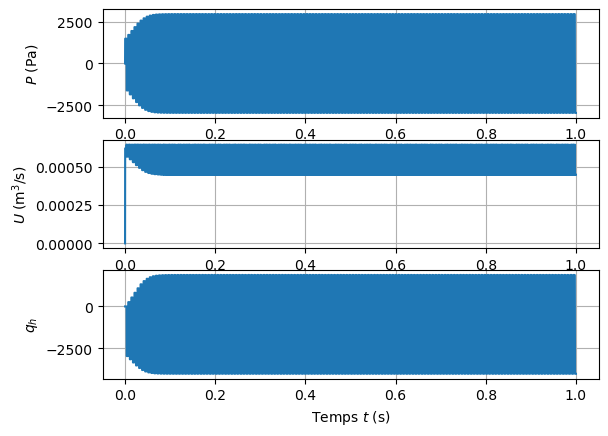

C:\Users\julie\AppData\Local\Temp\ipykernel_9920\3332865633.py:281: RuntimeWarning: divide by zero encountered in divide
  Z_e2 = Zc * (1+R_e2) / (1-R_e2)
C:\Users\julie\AppData\Local\Temp\ipykernel_9920\3332865633.py:281: RuntimeWarning: invalid value encountered in divide
  Z_e2 = Zc * (1+R_e2) / (1-R_e2)


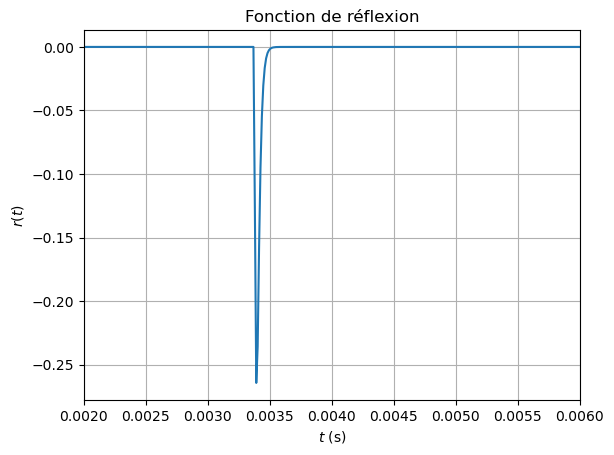

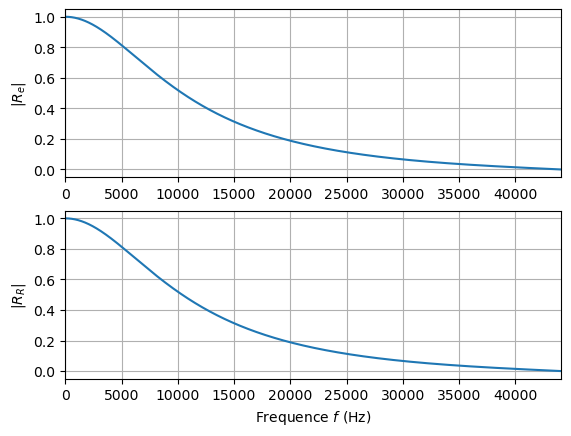

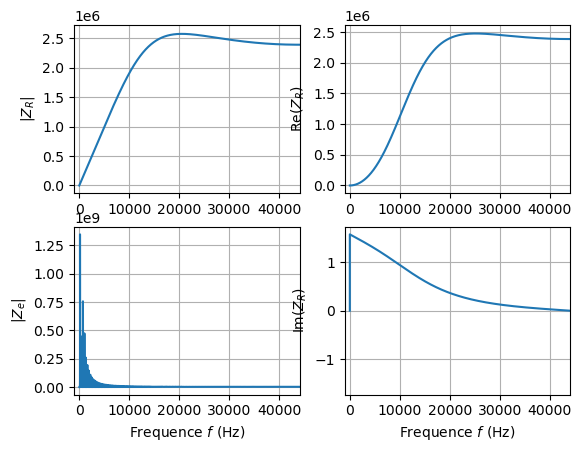

In [2]:
###############################################################################
                    # MODELE PHYSIQUE DE CLARINETTE

           # D'après l"article d'Ollivier, Dalmont, Kergomard
      # Fonction de réflexion d'après Guillemain, Kergomard, Voinier
###############################################################################

# PARAMETRES PHYSIQUES ET VARIABLES

T_sec = 1         # durée simulée (s)

# Paramètres physiques

T_deg = 20             # température (°C)
T_K = 273.15 + T_deg   # température (K)
c = 20.05*np.sqrt(T_K) # vitesse du son (m/s)
rho = 1.292*273.15/T_K # masse volumique de l'air (kg/m^3)
lv = 4e-8
lt = 5.6e-8
cp_over_cv = 1.402

# Paramètres d'anche et de résonateur

gamma = 0.38           # pression dans la bouche adimensionnée --> entre 1/3 et 1/2
zeta = 0.4            # paramètre d'ouverture d'anche adimensionné --> entre 0.2 et 0.6

H = 10**(-3)           # ouverture d'anche au repos (m)
w = 1.3*10**(-2)       # largeur du canal d'anche (m)
P_M = 10*10**3         # pression de plaquage (Pa)
Ks = P_M / H           # raideur anche (Pa/m)
P_m = gamma * P_M      # pression dans la bouche (Pa)
U_A = w*H*np.sqrt(2/rho*P_M)
Zc = zeta*P_M/U_A      # impédance caractéristique (kg/s)
S = rho*c/Zc           # section du résonateur (m^2)
R = np.sqrt(S/np.pi)   # rayon du résonateur (m)
L = 0.58               # longueur du résonateur (m)
a = R
alpha = 2/(R*c**(3/2)) * ( np.sqrt(lv) + (cp_over_cv-1)*np.sqrt(lt))

# Paramètres utiles pour la simulation

T = 2*L/c               # temps de parcours d'un aller-retour (s)
#delta_t = T/128         # pas de temps (s)
#fs = int(np.rint(1/delta_t)) # fréquence d'échantillonage
fs = 44100*2
delta_t = 1/fs

# FONCTIONS

# Caractéristique non-linéaire
@njit
def F(P, gamma, zeta, L, P_M, Zc):
    """
    Caractéristique non-linéaire F telle que u = F(P_m-p)

    Parameters
    ----------
        P : float, pression dans le bec (Pa)
        gamma : float, pression dans la bouche adimensionnée
        zeta : float, paramètre d'ouverture d'anche adimensionné
        P_M : float, pression de plaquage
        Zc : float, impédance caractéristique
    Returns
    -------
        U : float, débit volumique dans le bec
    """
    p = P/P_M # pression adimensionnée
    if np.abs(gamma-p) <= 1:
        u = zeta * (1+p-gamma) * np.sqrt(np.abs(gamma-p)) * (gamma-p)/np.abs(gamma-p) # débit adimensionné
    else :
        u = 0
    U = u*P_M/Zc # débit dimensionné
    return U

@njit
def func_dicho(P, params):
    """
    Fonction dont on veut trouver le zéro par dichotomie

    Parameters
    ----------
        P : float, valeur de la pression dans le bec à laquelle on évalue la fonction
        params : array
    """
    qh, gamma, zeta, L, P_M, Zc = params[0], params[1], params[2], params[3], params[4], params[5]
    return F(P, gamma, zeta, L, P_M, Zc) - 1/Zc*(P-qh)

@njit
def dichotomie(func, params, a, b, n, tol=1e-9):
    """
    Trouver l'abcisse m tel que func(m) = 0 par dichotomie

    Parameters
    ----------
        func : fonction, fonction dont on cherche l'annulation
        params : array, paramètres d'entrée de la fonction
        a : float, borne minimale de l'intervalle de recherche
        b : float, borne maximale de l'intervalle de recherche
        tol : float, tolérance de précision sur la valeur de l'abcisse obtenue

    Returns
    -------
        m : float, abcisse pour laquelle la fonction s'annule
    """

    if func(a,params)*func(b,params) > 0:
        #print("Mauvais choix des bornes de l'intervalle, n=",n)
        return (a+b)/2
    else :
        m = (a+b)/2

        while np.abs(a-b) > tol:
            if func(m,params) == 0.:
                return m
            elif func(a,params)*func(m,params) > 0:
                a = m
            else :
                b = m
            m = (a+b)/2

        return m


# BOUCLE TEMPORELLE

D = int(np.rint(2*L/c * fs))
beta = 2*R/(c/fs)
n1 = 0.167
d1 = 1.393
d2 = 0.457

@njit
def execution(T_sec, delta_t, gamma, zeta, L, P_M, Zc):

    temps = np.arange(0, T_sec, delta_t)
    N = len(temps)

    # Initialisation
    U, P, P_ext, qh = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)

    # Boucle
    for n in range(1,N):

        # calcul de qh à l'instant
        if n >= 2 :
            qh_prev2 = qh[n-2]
        else :
            qh_prev2 = 0

        if n >= D :
            q0_D = P[n-D] + Zc*U[n-D]
        else :
            q0_D = 0

        if n >= D+1 :
            q0_D1 = P[n-D-1] + Zc*U[n-D-1]
        else :
            q0_D1 = 0

        if n >= D+2:
            q0_D2 = P[n-D-2] + Zc*U[n-D-2]
        else :
            q0_D2 = 0

        qh[n] = -2*(1-d2*beta**2)*qh[n-1] - (1 - d1*beta + d2*beta**2)*qh_prev2 \
            - (1+n1*beta)*q0_D - 2*q0_D1 - (1-n1*beta)*q0_D2
        qh[n] /= (1 + d1*beta + d2*beta**2)

        # calcul de q et f à l'instant t
        # trouver l'intersection entre la courbe F(P) et la droite U = 1/Zc*(P-qh) par dichotomie
        P[n] = dichotomie(func_dicho, [qh[n], gamma, zeta, L, P_M, Zc], -P_M, P_M, n)
        U[n] = F(P[n], gamma, zeta, L, P_M, Zc)
        P_ext[n] = (P[n]+U[n] - (P[n-1]+U[n-1])) / delta_t

    return temps, U, P, P_ext, qh


def simulation(T_sec, delta_t, gamma, zeta, L, P_M, Zc, ret_time=False): #Remise en forme pour pouvoir cartographier ensuite
    start = time()
    _, _, P, _, _ = execution(T_sec, delta_t, gamma, zeta, L, P_M, Zc)
    stop = time()
    if ret_time:
        return P, stop-start
    else:
        return P

start = time()
temps, U, P, P_ext, qh = execution(T_sec, delta_t, gamma, zeta, L, P_M, Zc)
stop = time()
print("Temps d'exécution (s) :", stop-start)

# AFFICHAGE

plt.figure()
plt.subplot(311)
plt.plot(temps,P)
plt.ylabel(r"$P$ (Pa)")
plt.grid()

plt.subplot(312)
plt.plot(temps,U)
plt.ylabel(r"$U$ (m$^3$/s)")
plt.grid()

plt.subplot(313)
plt.plot(temps,qh)
plt.xlabel(r"Temps $t$ (s)")
plt.ylabel(r"$q_h$")
plt.grid()
plt.show()

#%%

# TRACE FONCTION DE REFLEXION

T_sec = 1
fs = 44100*2
temps = np.arange(0, T_sec, 1/fs)
N = len(temps)

D = int(np.rint(2*L/c * fs))
beta = 2*R/(c/fs)
n1 = 0.167
d1 = 1.393
d2 = 0.457

q0 = np.zeros(N)
q0[0] = 1 # impulsion
qi = np.zeros(N)

for n in range(1,N):

    # calcul de qh à l'instant
    if n >= 2 :
        qi_prev2 = qi[n-2]
    else :
        qi_prev2 = 0

    if n >= D :
        q0_D = q0[n-D]
    else :
        q0_D = 0

    if n >= D+1 :
        q0_D1 = q0[n-D-1]
    else :
        q0_D1 = 0

    if n >= D+2:
        q0_D2 = q0[n-D-2]
    else :
        q0_D2 = 0

    qi[n] = -2*(1-d2*beta**2)*qi[n-1] - (1 - d1*beta + d2*beta**2)*qi_prev2 \
        - (1+n1*beta)*q0_D - 2*q0_D1 - (1-n1*beta)*q0_D2
    qi[n] /= (1 + d1*beta + d2*beta**2)
    # print(qi[n])

# # fonction de réflexion théorique (pertes mais pas de rayonnement) --Chaigne
# r_th = np.zeros(N)
# x = 2*L
# B = 1.044/R * np.sqrt(2*lv/c)
# D2 = B*x/2
# r_th[D+1:] = D2/np.sqrt(np.pi) * np.exp(-D2**2/(temps[D+1:]-x/c))/(temps[D+1:]-x/c)**(3/2) * np.exp(-1.080*x*lv/R**2)
# r_th /= np.max(np.abs(r_th))

freq = np.linspace(0,fs, fs)
k = 2*np.pi*freq/c
z = np.exp(2j*np.pi*freq/fs)

R_e = np.fft.fft(qi,fs)
R_r = R_e * z**D
Z_r = Zc * (1+R_r) / (1-R_r)
Z_e = Zc * (1+R_e) / (1-R_e)

R_r3 = (1 + n1*1j*k*R) / (1 + d1*1j*k*R + d2*(1j*k*R)**2)
R_r2 = ((1+n1*beta)+2*z**(-1)+(1-n1*beta)*z**(-2))/((1+d1*beta+d2*beta**2)+2*(1-d2*beta**2)*z**(-1)+(1-d1*beta+d2*beta**2)*z**(-2))
R_e2 = R_r2 * z**(-D)
Z_r2 = Zc * (1+R_r2) / (1-R_r2+1e-14)
Z_r3 = Zc * (1+R_r3) / (1-R_r3+1e-14)
Z_e2 = Zc * (1+R_e2) / (1-R_e2)
r2 = np.fft.ifft(R_r2,fs)

plt.figure()
plt.plot(temps,qi)
plt.xlabel("$t$ (s)")
plt.ylabel("$r(t)$")
plt.title("Fonction de réflexion")
plt.xlim(0.002,0.006)
plt.grid()

plt.figure()
plt.subplot(211)
plt.plot(freq,np.abs(R_e))
#plt.plot(freq,np.abs(R_e2),'--')
plt.ylabel(r"$|R_e|$")
plt.xlim(0,fs/2)
plt.grid()
plt.subplot(212)
plt.plot(freq,np.abs(R_r))
#plt.plot(freq,np.abs(R_r2),'--')
#plt.plot(freq,np.abs(R_r3),'--')
plt.ylabel(r"$|R_R|$")
plt.xlabel(r"Frequence $f$ (Hz)")
plt.xlim(0,fs/2)
plt.grid()

plt.figure()
plt.subplot(221)
plt.plot(freq, np.abs(Z_r))
#plt.plot(freq, np.abs(Z_r2),'--')
#plt.plot(freq, np.abs(Z_r3),'--')
plt.ylabel(r"$|Z_R|$")
plt.xlim(-1000,fs/2)
plt.grid()
plt.subplot(223)
plt.plot(freq, np.abs(Z_e))
#plt.plot(freq, np.abs(Z_e2),'--')
plt.ylabel(r"$|Z_e|$")
plt.xlabel(r"Frequence $f$ (Hz)")
plt.xlim(-1000,fs/2)
plt.grid()
plt.subplot(222)
plt.plot(freq,Z_r.real)
#plt.plot(freq, np.real(Z_r2),'--')
plt.ylabel(r"Re($Z_R$)")
plt.xlim(-1000,fs/2)
plt.grid()
plt.subplot(224)
plt.plot(freq,np.angle(Z_r))
#plt.plot(freq, np.angle(Z_r2),'--')
plt.ylabel(r"Im($Z_R$)")
plt.xlabel(r"Frequence $f$ (Hz)")
plt.xlim(-1000,fs/2)
plt.grid()

#%%

# EXPORT AUDIO

#main_path = os.path.expanduser('~') + "\Documents\M2 ATIAM\Projets et applications musicales\Modele physique"
#os.chdir(main_path+'\Audio')

def wave(data,fs,title):
    """
    write a wave audio file

    Parameters
    ----------
    data : 1D-array, values to be written
    fs : int, sample rate
    title : str, title of the wave file
    """
    # normalize the data to have a good amplitude in 16-bit
    amplitude = np.iinfo(np.int16).max
    data_norm = data/np.max(data)*int(amplitude/2)
    write(title+'.mp3',fs,data_norm.astype(np.int16))

#wave(P, fs, "clarinette_silva_g0.38_z0.4")

##Section Ib) : Modèle du violon par Coline

Echantillon 1000/4410
Echantillon 2000/4410
Echantillon 3000/4410
Echantillon 4000/4410
Temps d'exécution (s) : 2.7780187129974365


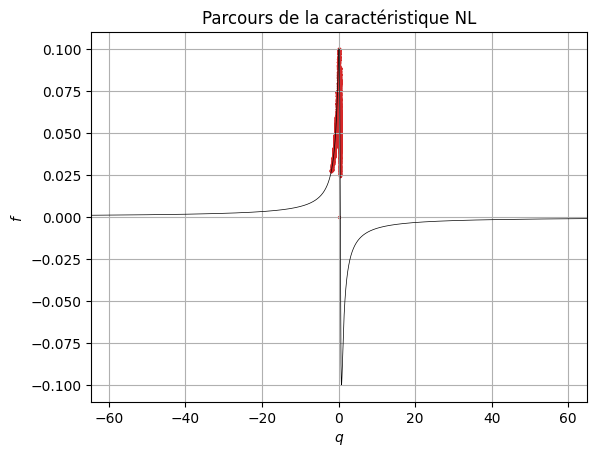

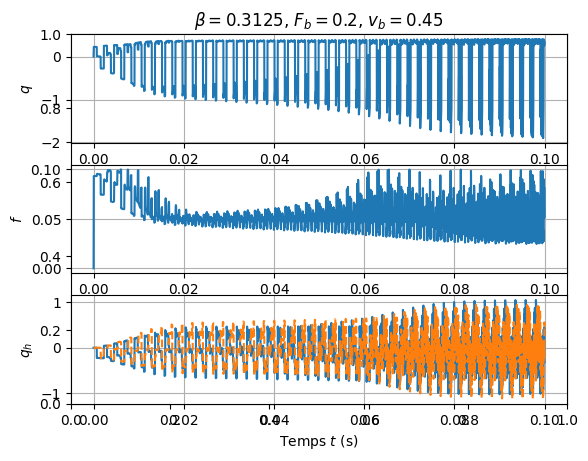

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


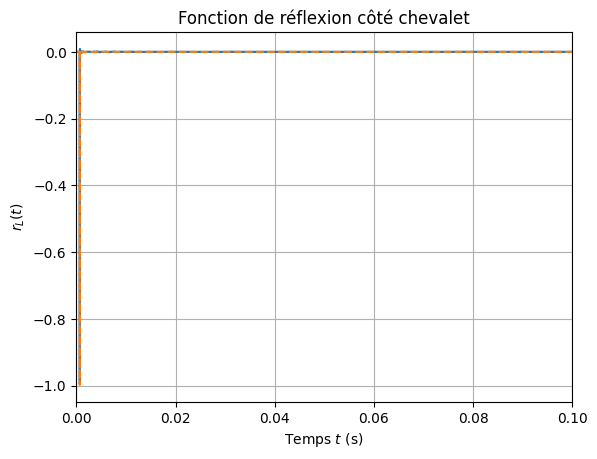

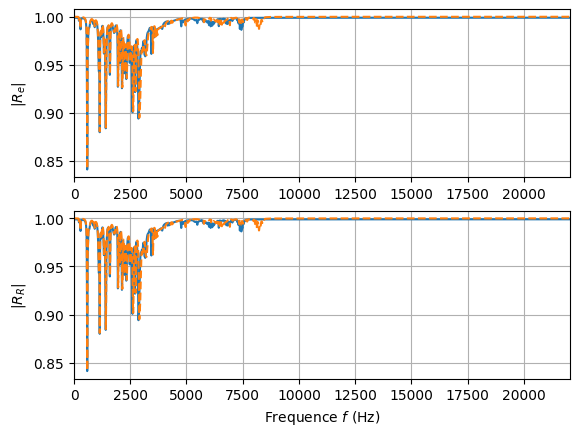

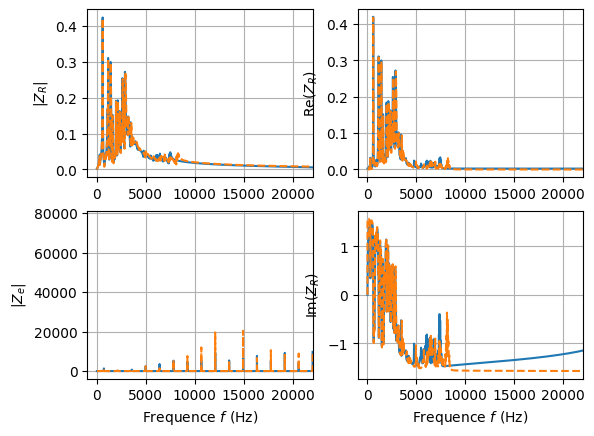

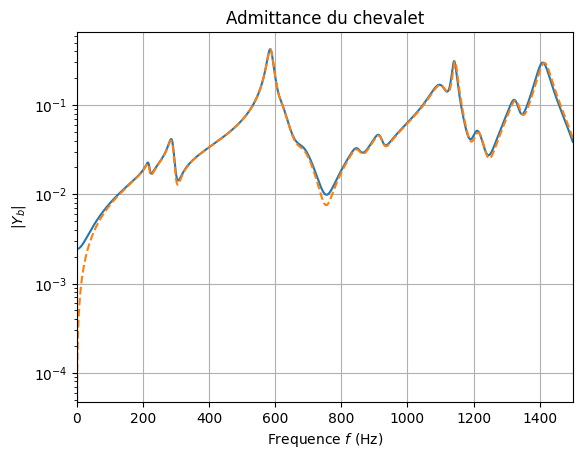

In [ ]:
######################################################################################
                     # MODELE PHYSIQUE DE CORDES FROTTEES

              # D'après les articles de Ollivier, Dalmont Kergomard
           # Point de contact entre l'archet et la corde : quelconque
# Fonction de réflexion construite à partir de l'admittance du chevalet (Debut et al)
#######################################################################################

# PARAMETRES PHYSIQUES ET VARIABLES

T_sec = 1    # durée de la simulation (s)

# Paramètres physiques liés à la corde

L = 0.325                 # longueur de la corde (m) --> à faire varier pour changer la freq
d = 0.45e-3               # diamètre de la corde LA (m)
R = d/2                   # rayon de la corde (m)
T = 6*9.81                # tension pour une corde de LA (N)
Area = np.pi*R**2         # section de la corde (m^2)
mu = 7.19595e-4           # masse linéique (kg/m)
rho = mu/Area             # masse volumique (kg/m3)
c = np.sqrt(T/mu)         # vitesse du son (m/s)
f0_th = c/(2*L)           # fréquence fondamentale attendue (Hz)
Zc = rho*c*Area           # impédance caractéristique (kg/s)
Yc = 1/Zc                 # admittance caractéristique (s/kg)
Yc_half = Yc/2

# Paramètres physiques liés à l'archet

Fb = 0.2      # force de l'archet (N) -- valeur réaliste = < 5 N
vb = 0.45       # vitesse de l'archet (m/s) -- valeur réaliste < 0.5 m/s
v0 = 0.05     # paramètre de contrôle tenant compte des coeffs de viscosité dynamique et statique (m/s)
              # valeur isssue de l'article de Weinreich -- a priori ne pas le modifier
beta = 5/16   # ratio du point de contact entre la corde et l'archet


# Paramètres utiles pour la simulation

L_L = L*beta             # longueur de la partie droite de la corde (m)
L_R = L*(1-beta)         # longueur de la partie droite de la corde (m)
T_L = 2*L_L/c            # temps de parcours d'un aller-retour sur la moitié gauche de la corde (s)
T_R = 2*L_R/c            # temps de parcours d'un aller-retour sur la moitié droite de la corde (s)
fs = 44100               # fréquence d'échantillonage (Hz)
delta_t = 1/fs           # pas de temps (s)

# IMPORT DES DONNEES

# main_path = os.path.expanduser('~') + "\Documents\M2 ATIAM\Projets et applications musicales"
# os.chdir(main_path+'\File_Debut_Et_al_2010')

# data = scipy.io.loadmat('CELLO_ModosXX.mat')

# Nmod = int(data['Nmod'][0])
# Wmod = data['Wmod'][:,0]
# Fmod = data['Fmod'][:,0]
# Zmod = data['Zmod'][:,0]
# Mmod = data['Mmod'][:,0]

# Admittance du chevalet - Vincent Debut et al

Nmod = 88 # nombre de modes
Wmod = np.array([  457.80459813,   606.16602347,   937.60287944,  1227.64940544, # pulsations des modes
        1292.72714884,  1423.82868046,  1784.60501254,  1926.15092272,
        2315.34911731,  2395.71314077,  2544.40317242,  2787.58727589,
        2961.55910617,  3187.55592203,  3348.0717585 ,  3637.01322936,
        3743.6192178 ,  3813.80570444,  4044.19124188,  4109.7108403 ,
        4259.99763199,  4495.74130246,  4604.29717327,  4709.40807563,
        4911.42640265,  5228.78675522,  5293.38745049,  5506.52503914,
        5748.97551311,  5852.00938903,  6070.49265205,  6140.11953925,
        6355.94299717,  6469.32878753,  6656.6473557 ,  6755.13656752,
        7063.18409084,  7270.34071089,  7350.97375391,  7579.96111789,
        7751.78717505,  7977.93827914,  8431.00662791,  8999.07332034,
        9160.24292933,  9336.9912637 ,  9545.93937675,  9833.84248228,
       10384.37700582, 10580.85065019, 10723.25648642, 10923.69958442,
       11098.51755904, 11270.09806843, 11842.74810213, 12096.92842441,
       12235.97179121, 12393.36048915, 12566.25049248, 12755.356287  ,
       12925.33907501, 13082.45822727, 13205.29275186, 13393.68733982,
       13573.86985808, 13762.46813201, 13942.2558396 , 14090.90896331,
       14215.26596544, 14509.95983076, 14767.92757604, 14848.56515504,
       15008.00687824, 15203.57408935, 15394.6528056 , 15555.73917704,
       15744.62252183, 15921.55722664, 16118.35026955, 16152.23298291,
       16703.52788634, 16860.09009122, 17036.19701086, 17220.04568628,
       17351.04178645, 17524.41430744, 17680.82463166, 17926.85978027])

Fmod = np.array([  72.86186476,   96.47431897,  149.22413292,  195.38647126,
        205.74391581,  226.60937261,  284.02870921,  306.55644049,
        368.499257  ,  381.28958858,  404.95434211,  443.65829426,
        471.34677101,  507.31528137,  532.86217019,  578.84863354,
        595.81550357,  606.98602985,  643.65302695,  654.08079491,
        677.99968069,  715.51945115,  732.79665459,  749.52557427,
        781.67778961,  832.18725847,  842.46877845,  876.39067924,
        914.97787063,  931.37622128,  966.14891258,  977.23037585,
       1011.57974601, 1029.62565502, 1059.43833108, 1075.11337598,
       1124.14066202, 1157.1106621 , 1169.94380947, 1206.38828036,
       1233.73524671, 1269.72831281, 1341.83638007, 1432.24700218,
       1457.89794212, 1486.02831322, 1519.28343827, 1565.10464064,
       1652.72493141, 1683.9946831 , 1706.65927586, 1738.56078571,
       1766.38393051, 1793.69181672, 1884.83190025, 1925.28595497,
       1947.4153941 , 1972.46458337, 1999.98088201, 2030.07800397,
       2057.13160493, 2082.13789466, 2101.68761643, 2131.67154636,
       2160.3484848 , 2190.36483235, 2218.97893472, 2242.63781417,
       2262.42984577, 2309.33183113, 2350.38867295, 2363.22254225,
       2388.59848063, 2419.72396898, 2450.13509119, 2475.77278347,
       2505.83450147, 2533.99453434, 2565.31511989, 2570.7077212 ,
       2658.44903018, 2683.36667899, 2711.39496577, 2740.65539124,
       2761.50406811, 2789.09716182, 2813.99063807, 2853.14834814])

Zmod = np.array([0.02806018, 0.03084333, 0.02508868, 0.01647275, 0.0289855, # coefficients d'amortissement zeta
       0.05352241, 0.02235392, 0.01746855, 0.02548642, 0.00635098,
       0.01663475, 0.01324522, 0.01415669, 0.00340841, 0.00990157,
       0.01794775, 0.02697258, 0.00742968, 0.03227202, 0.0055932 ,
       0.00763441, 0.00739527, 0.03432816, 0.00903569, 0.01322705,
       0.01257962, 0.01198943, 0.0119133 , 0.00586819, 0.00760282,
       0.00673269, 0.01474132, 0.00853252, 0.00962712, 0.007925  ,
       0.01779052, 0.01819473, 0.00539287, 0.00366558, 0.00302975,
       0.00513375, 0.06657177, 0.00757581, 0.00265573, 0.00492994,
       0.00475768, 0.02909748, 0.00620675, 0.00313591, 0.00554923,
       0.00449006, 0.00331862, 0.00343261, 0.00545233, 0.0120341 ,
       0.00400778, 0.00494859, 0.00345198, 0.00217223, 0.00213778,
       0.00364035, 0.00632312, 0.00544423, 0.00333903, 0.00347037,
       0.00344806, 0.0057395 , 0.00760761, 0.00775131, 0.00150851,
       0.00404056, 0.00823238, 0.00316784, 0.00210596, 0.00272994,
       0.0029931 , 0.00348758, 0.00344996, 0.00168281, 0.01197384,
       0.00121528, 0.00221253, 0.00151954, 0.00311053, 0.00305237,
       0.00203544, 0.00258697, 0.00372498])

Mmod = np.array([1.79748750e+01, 3.04600824e+00, 9.81389260e+02, 2.02503484e-01, # masses modales
       1.46993879e+00, 1.28841829e+00, 3.70521551e+00, 2.65211429e+00,
       2.21439755e-01, 4.26311207e-01, 1.22402456e+00, 6.29059377e-01,
       1.37506978e-01, 1.61852196e+01, 3.58186331e-01, 3.82305003e+00,
       5.64738176e-01, 7.22966642e+00, 1.89860600e+00, 4.44797989e-01,
       5.07945623e-01, 3.09307420e-01, 8.22831558e-01, 3.48026741e-01,
       1.81168924e-01, 3.15361554e-01, 1.15635779e+00, 1.09290223e-01,
       3.09989415e-01, 3.14411969e+00, 3.23123953e-01, 9.40308038e-02,
       8.85327100e-01, 6.00336094e-01, 1.17535807e+00, 1.79307837e-01,
       1.03311117e+00, 1.69378791e+01, 8.38118985e-01, 2.58749031e+00,
       1.94356075e+00, 1.26477974e-01, 2.24812227e+00, 9.30448785e+00,
       5.00597406e+00, 1.07561238e+01, 1.52485138e+00, 6.29933702e+01,
       2.76327629e+00, 3.39844837e+00, 8.52437496e+00, 8.73899606e+00,
       5.34196876e+01, 3.17788570e+02, 2.41605518e+00, 3.15750540e+00,
       8.73136999e+00, 2.47532939e+01, 2.38016800e+01, 7.97398925e+00,
       5.53424226e+00, 4.09066836e+00, 2.80667548e+00, 2.49391712e+00,
       1.96482673e+00, 2.29333663e+00, 1.91165987e+00, 3.56257015e+00,
       3.71703127e+00, 3.95962739e+00, 1.01390854e+01, 6.81652222e+00,
       3.70618345e+01, 9.14412688e+00, 3.10323298e+00, 2.73507240e+00,
       2.75774907e+00, 7.20179810e+00, 1.21365065e+01, 4.68823532e+00,
       1.72753068e+01, 3.62914623e+00, 2.59365414e+00, 1.14876031e+00,
       1.75412353e+00, 5.35971976e+00, 1.66880236e+01, 1.33587353e+02])

# Adaptation violoncelle vers violon
# freq de résonnance principale shiftée de 200 Hz à 500 Hz

Wmod *= 3
Mmod *= 1/10

# FONCTIONS

# Caractéristique non-linéaire
@njit
def F(q, vb, Fb, v0, L):
    """
    Caractéristique non-linéaire F telle que
        f = F(q) = Fb * (p-q)/v0 / (1 + ((p-q)/v0)^2 )
    La pente en p=q est finie de manière à prendre en compte la torsion

    Parameters
    ----------
        q : float, vitesse transverse de la corde au point de contact avec l'archet
        vb : float, vitesse de l'archet (fixe)
        Fb : float, force de l'archet
        v0 : float, paramètre de contrôle
        L : longueur de la corde

    Returns
    -------
        f : float, force transverse appliquée sur la corde au point de contact
    """
    f = Fb * (vb-q)/v0 / (1+((vb-q)/v0)**2)
    return f

@njit
def F_deriv(q, vb, Fb, v0, L):
    """
    Dérivée de la caractéristique non linéaire
    """
    df = -Fb/v0 * (v0**2-(vb-q)**2) / (v0**2+(vb-q)**2)**2
    return df

@njit
def func_Newton(q, params, Yc_half=Yc_half):
    """
    Fonction dont on veut trouver le zéro avec la méthode de Newton

    Parameters
    ----------
        q : float, vitesse transverse de la corde au point de contact avec l'archet
        params : array
        Yc : float, admittance caractéristique
    """
    q_iL, q_iR, vb, Fb, v0, L = params[0], params[1], params[2], params[3], params[4], params[5]
    return F(q, vb, Fb, v0, L) - 1/Yc_half*(q-q_iL-q_iR)

@njit
def func_deriv_Newton(q, params, Yc_half=Yc_half):
    """
    Dérivée de la fonction dont on veut trouver le zéro avec Newton
    """
    _, _, vb, Fb, v0, L = params[0], params[1], params[2], params[3], params[4], params[5]
    return F_deriv(q, vb, Fb, v0, L) - 1/Yc_half

@njit
def dichotomie(func, params, a, b, n, tol=1e-9):
    """
    Trouver l'abcisse m tel que func(m) = 0 par dichotomie

    Parameters
    ----------
        func : fonction, fonction dont on cherche l'annulation
        params : array, paramètres d'entrée de la fonction
        a : float, borne minimale de l'intervalle de recherche
        b : float, borne maximale de l'intervalle de recherche
        tol : float, tolérance de précision sur la valeur de l'abcisse obtenue

    Returns
    -------
        m : float, abcisse pour laquelle la fonction s'annule
    """

    if func(a,params)*func(b,params) > 0:
        print("Mauvais choix des bornes de l'intervalle, n=",n)
    else :
        m = (a+b)/2

        while np.abs(a-b) > tol:
            if func(m,params) == 0.:
                return m
            elif func(a,params)*func(m,params) > 0:
                a = m
            else :
                b = m
            m = (a+b)/2

        return m


@njit
def Newton(func, func_deriv, params, x0, n, Yc_half=Yc_half, tol=1e-9, maxiter=1000):
    """
    Trouver l'abcisse m tel que func(m) = 0 par la méthode de Newton

    Parameters
    ----------
        func : fonction, fonction dont on cherche le zéro
        func_deriv : fonction, dérivée de la fonction func
        params : array, paramètres d'entrée de la fonction
        x0 : float, guess initial pour le zéro
        Yc : float, admittance caractéristique
        tol : float, tolérance de précision sur la valeur de l'abcisse obtenue
        maxiter : int, nombre maximal d'itérations

    Returns
    -------
        m : float, abcisse pour laquelle la fonction s'annule
    """
    x = x0
    for i in range(maxiter):
        f = func(x, params)
        df = func_deriv(x, params)

        if np.abs(df) < 1e-15:
            print("Erreur : division par 0 dans la méthode de Newton pour n =",n)
            break

        dx = f/df
        x = x - dx

        if np.abs(dx) < tol :
            return x

    if np.abs(dx) > tol :
        print(np.abs(dx))
        print("Erreur : la méthode de Newton n'a pas convergé pour n =",n)

    return x

@njit
def intersections(q_iL, q_iR, vb, Fb, v0, L, q_min, n, Yc_half=Yc_half):
    """
    Trouver les intersections entre la courbe non linéaire et la droite
    """

    inter = np.zeros((3,2))
    nb_inter = 0

    q_vals = np.linspace(q_min, -q_min, 100)
    params = [q_iL, q_iR, vb, Fb, v0, L]
    for i in range(1,len(q_vals)):
        if func_Newton(q_vals[i-1], params) * func_Newton(q_vals[i], params) < 0 :
            q_intersect = dichotomie(func_Newton, params, q_vals[i-1], q_vals[i], n)
            inter[nb_inter] = [q_intersect, F(q_intersect, vb, Fb, v0, L)]
            nb_inter += 1


    return inter, nb_inter

@njit
def hysteresis(q_prev, state_prev, q_iL, q_iR, vb, Fb, v0, L, q_min, n, Yc_half=Yc_half):
    """
    Trouver q et f à l'instant n en prenant en compte l'hystérésis
    Avec une dichotomie = méthode un peu plus lente mais plus robuste et précise
    """
    intersect, nb_inter = intersections(q_iL, q_iR, vb, Fb, v0, L, q_min, n)

    if nb_inter == 0 :
        print("Pas de point d'intersection trouvé pour n=",n)

    elif nb_inter == 1 :
        if np.abs(intersect[0,0]-vb) <= v0:
            return intersect[0], 1
        else :
            return intersect[0], -1

    else :
        if nb_inter == 2:
            print("2 sols")

        # la solution n'est jamais celle du milieu
        # rester dans l'état précédent si c'est possible
        if state_prev == -1:
            return intersect[0], -1
        else :
            return intersect[-1], 1

@njit
def hysteresis2(q_prev, q_iL, q_iR, vb, Fb, v0, L, n, Yc_half=Yc_half):
    """
    Trouver q et f à l'instant n en prenant en compte l'hystérésis
    Avec Newton  = méthode plus rapide mais moins précise
    """
    params = [q_iL, q_iR, vb, Fb, v0, L]
    x0 = q_prev # partir de la solution précédente pour rester dans le même régime
    q_sol = Newton(func_Newton, func_deriv_Newton, params, x0, n)
    f_sol = F(q_sol, vb, Fb, v0, L)

    return q_sol, f_sol

# BOUCLE TEMPORELLE
@njit
def execution(T_sec, delta_t, vb, Fb, v0, L):
    temps = np.arange(0., T_sec, delta_t)
    N = len(temps)
    state = np.zeros(N)  # -1 for slip, 1 for stick
    state[0] = -1

    # Initialisation
    f, q, q_iL, q_iR = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)

    D_R = int(np.rint(T_R*fs)) # temps de parcours aller-retour de la moitié droite de la corde en samples
    D_L = int(np.rint(T_L*fs))

    bm = 2*delta_t / Mmod
    a_m0 = (Wmod*delta_t)**2 + 4*Zmod*Wmod*delta_t + 4
    a_m1 = 2 * (Wmod**2*delta_t**2 - 4)
    a_m2 = (Wmod*delta_t)**2 - 4*Zmod*Wmod*delta_t + 4
    qo = np.zeros(N)
    qo[0] = 1
    fm = np.zeros((N,Nmod))
    qtot = np.zeros(N)

    # Boucle
    for n in range(1, N):

        # Côté tête du violon (impulsion)
        q_iR[n] = - (q_iL[n-D_R] + Yc_half*f[n-D_R])

        # Côté chevalet (admittance du chevalet)
        if n >= 2 :
            qi_prev2 = q_iL[n-2]
            fm_prev2 = fm[n-2,:]
            qtot_prev2 = qtot[n-2]
        else :
            qi_prev2 = 0
            fm_prev2 = np.zeros(Nmod)
            qtot_prev2 = 0

        if n >= D_L :
            qo_D = 0.999*(q_iR[n-D_L] + Yc_half*f[n-D_L])
        else :
            qo_D = 0

        if n >= D_L+1 :
            qo_D1 = 0.999*(q_iR[n-D_L-1] + Yc_half*f[n-D_L-1])
        else :
            qo_D1 = 0

        if n >= D_L+2:
            qo_D2 = 0.999*(q_iR[n-D_L-2] + Yc_half*f[n-D_L-2])
        else :
            qo_D2 = 0


        gm = bm * (-qo_D - qi_prev2 +qo_D2) - a_m1*fm[n-1] - a_m2*fm_prev2

        q_iL[n] = (-qo_D - Zc * np.sum(gm/a_m0)) / (1 + Zc * np.sum(bm/a_m0))
        qtot[n] = q_iL[n] - qo_D

        fm[n] = (- a_m1*fm[n-1] - a_m2*fm_prev2 + bm*(qtot[n]-qtot_prev2)) / a_m0


        # Calcul de q et f à l'instant t
        # Méthode 1 : Dichotomie : plus lent mais plus précis
        [q[n], f[n]], s = hysteresis(q[n-1], state[n-1], q_iL[n], q_iR[n], vb, Fb, v0, L, q_min, n)
        state[n] = s
        # Méthode 2 : Newton : plus rapide mais moins précis
        #q[n], f[n] = hysteresis2(q[n-1], q_iL[n], q_iR[n], n)

        if n % 1000 == 0:
            print(f"Echantillon {n}/{N}")

    return temps, f, q, q_iL, q_iR

def simulation(T_sec, delta_t, vb, Fb, L, v0, ret_time=False): #Remise en forme pour pouvoir cartographier ensuite
    q_vals = np.linspace(vb-100, vb+100, 10000)
    f_vals = F(q_vals, vb, Fb, v0, L)
    q_min = q_vals[np.argmin(np.abs(f_vals-0.01*np.max(f_vals)))]
    temps, f, q, q_iL, q_iR = execution(T_sec, delta_t, vb, Fb, v0, L)
    stop = time()
    if ret_time:
        return q, stop-start
    else:
        return q

start = time()

q_vals = np.linspace(vb-100, vb+100, 10000)
f_vals = F(q_vals, vb, Fb, L, v0)
q_min = q_vals[np.argmin(np.abs(f_vals-0.01*np.max(f_vals)))]
temps, f, q, q_iL, q_iR = execution(T_sec, delta_t, vb, Fb, L, v0)

stop = time()
print("Temps d'exécution (s) :", stop-start)

# AFFICHAGE

#plt.close('all')

plt.figure()
plt.plot(q_vals,f_vals, 'k', lw=0.5)
plt.scatter(q, f, s=2, c='tab:red')
plt.grid()
plt.xlabel('$q$')
plt.ylabel('$f$')
plt.xlim(q_min,vb+abs(q_min))
plt.title("Parcours de la caractéristique NL")

plt.figure()
plt.title(r"$\beta =$"+str(beta)+", $F_b =$"+str(Fb)+ ", $v_b =$"+str(vb))
plt.subplot(311)
plt.plot(temps,q)
plt.ylabel(r"$q$")
plt.grid()

plt.subplot(312)
plt.plot(temps,f)
plt.ylabel(r"$f$")
plt.grid()

plt.subplot(313)
plt.plot(temps,q_iL,label=r'$q_{iL}$')
plt.plot(temps,q_iR,'--',label=r'$q_{iR}$')
plt.xlabel(r"Temps $t$ (s)")
plt.ylabel(r"$q_h$")
plt.grid()
plt.show()

#%%

# TRACE FONCTION REFLEXION

# main_path = os.path.expanduser('~') + "\Documents\M2 ATIAM\Projets et applications musicales"
# os.chdir(main_path+'\File_Debut_Et_al_2010')

# data = scipy.io.loadmat('CELLO_ModosXX.mat')

# Nmod = int(data['Nmod'][0])
# Wmod = data['Wmod'][:,0]
# Fmod = data['Fmod'][:,0]
# Zmod = data['Zmod'][:,0]
# Mmod = data['Mmod'][:,0]

T_sec = 1
fs = 44100
Ts = 1/fs
temps = np.arange(0, T_sec, 1/fs)
N = len(temps)

D = int(np.rint(2*L_L/c*fs))
bm = 2*Ts / Mmod
a_m0 = (Wmod*Ts)**2 + 4*Zmod*Wmod*Ts + 4
a_m1 = 2 * (Wmod**2*Ts**2 - 4)
a_m2 = (Wmod*Ts)**2 - 4*Zmod*Wmod*Ts + 4
qo = np.zeros(N)
qo[0] = 1
qi = np.zeros(N)
fm = np.zeros((N,int(Nmod)))
qtot = np.zeros(N)

for n in range(1,N) :
    # calcul de qh à l'instant
    if n >= 2 :
        qi_prev2 = qi[n-2]
        fm_prev2 = fm[n-2,:]
        qtot_prev2 = qtot[n-2]
    else :
        qi_prev2 = 0
        fm_prev2 = np.zeros(Nmod)
        qtot_prev2 = 0

    if n >= D :
        qo_D = qo[n-D]*0.999
    else :
        qo_D = 0

    if n >= D+1 :
        qo_D1 = qo[n-D-1]*0.999
    else :
        qo_D1 = 0

    if n >= D+2:
        qo_D2 = qo[n-D-2]*0.999
    else :
        qo_D2 = 0

    gm = bm * (-qo_D - qi_prev2 +qo_D2) - a_m1*fm[n-1] - a_m2*fm_prev2

    qi[n] = (-qo_D - Zc * np.sum(gm/a_m0)) / (1 + Zc * np.sum(bm/a_m0))
    qtot[n] = qi[n] - qo_D

    fm[n] = (- a_m1*fm[n-1] - a_m2*fm_prev2 + bm*(qtot[n]-qtot_prev2)) / a_m0



freq = np.linspace(0,fs, fs)
k = 2*np.pi*freq/c
z = np.exp(2j*np.pi*freq/fs)

R_e = np.fft.fft(qi,fs) # fonction de réflexion au point de contact avec l'archet
R_r = R_e * z**D        # fonction de réflexion au chevalet
Y_r = Yc * (1+R_r) / (1-R_r)  # admittance au chevalet
Y_e = Yc * (1+R_e) / (1-R_e)  # admittance au point de contact avec l'archet

# théorie

W = 2 * np.pi * freq # pulsations

H = np.zeros(len(W), dtype=complex) # admittance au chevalet
for i in range(len(Wmod)):
    H_mod = 1j*W / (Mmod[i] * (Wmod[i]**2 - W**2 + 2j*W*Wmod[i]*Zmod[i]))
    H += H_mod

R_r2 = (H-Yc)/(H+Yc)
R_e2 = R_r2 * z**(-D)
r2 = np.fft.ifft(R_e2,fs)
Y_e2 =  Yc * (1+R_e2) / (1-R_e2)

plt.figure()
plt.plot(temps,qi)
plt.plot(temps,r2,'--')
plt.xlabel("Temps $t$ (s)")
plt.ylabel(r"$r_L(t)$")
plt.title("Fonction de réflexion côté chevalet")
plt.grid()
plt.xlim(0,0.1)

plt.figure()
plt.subplot(211)
plt.plot(freq,np.abs(R_e))
plt.plot(freq,np.abs(R_e2),'--')
plt.ylabel(r"$|R_e|$")
plt.xlim(0,fs/2)
plt.grid()
plt.subplot(212)
plt.plot(freq,np.abs(R_r))
plt.plot(freq,np.abs(R_r2),'--')
plt.ylabel(r"$|R_R|$")
plt.xlabel(r"Frequence $f$ (Hz)")
plt.xlim(0,fs/2)
plt.grid()

plt.figure()
plt.subplot(221)
plt.plot(freq, np.abs(Y_r))
plt.plot(freq,np.abs(H),'--')
plt.ylabel(r"$|Z_R|$")
plt.xlim(-1000,fs/2)
plt.grid()
plt.subplot(223)
plt.plot(freq, np.abs(Y_e))
plt.plot(freq, np.abs(Y_e2),'--')
plt.ylabel(r"$|Z_e|$")
plt.xlabel(r"Frequence $f$ (Hz)")
plt.xlim(-1000,fs/2)
plt.grid()
plt.subplot(222)
plt.plot(freq,Y_r.real)
plt.plot(freq,np.real(H),'--')
plt.ylabel(r"Re($Z_R$)")
plt.xlim(-1000,fs/2)
plt.grid()
plt.subplot(224)
plt.plot(freq,np.angle(Y_r))
plt.plot(freq,np.angle(H),'--')
plt.ylabel(r"Im($Z_R$)")
plt.xlabel(r"Frequence $f$ (Hz)")
plt.xlim(-1000,fs/2)
plt.grid()

plt.figure()
plt.semilogy(freq,np.abs(Y_r))
plt.semilogy(freq,np.abs(H),'--')
plt.grid()
plt.xlim(0,1500)
plt.xlabel("Frequence $f$ (Hz)")
plt.ylabel(r'$|Y_b|$')
plt.title("Admittance du chevalet")

#%%

# EXPORT AUDIO

#main_path = os.path.expanduser('~') + "\Documents\M2 ATIAM\Projets et applications musicales\Modele physique"
#os.chdir(main_path+'\Audio')

def wave(data,fs,title):
    """
    write a wave audio file

    Parameters
    ----------
    data : 1D-array, values to be written
    fs : int, sample rate
    title : str, title of the wave file
    """
    # normalize the data to have a good amplitude in 16-bit
    amplitude = np.iinfo(np.int16).max
    data_norm = data/np.max(data)*int(amplitude/2)
    write(title+'.wav',fs,data_norm.astype(np.int16))

#wave(q, int(1/delta_t), "string_adm_bridge")

# Section II : Définition des descripteurs

## Sont gardés ceux de bases (codés par Baptiste) et sont highlightés ceux vraiment utilisés dans le code:

In [3]:
#Calculs des descripteurs = labels des points de la cartographie
from scipy.signal import butter, filtfilt
from scipy.stats import gmean

def D_epsilon1(q): # établit si oui ou non il y a du son
    """
    q : grandeur physique : P le champ de pression pour la clarinette, v pour le violon (approximation de continuité pour la pression rayonnée).
    """
    #eps = 2.5 # valeur arbitraire, aucune valeur donnée dans le papier de Christophe mais d'après les figures données 10 devrait suffire, P n'excédant pas 0.05 en fin de signal.
    #n = len(q)
    eps = 0.1
    #moy_last = np.abs((1/n)*np.sum(q[n-(n//3+1):n]))
    #print(moy_last)
    N = len(q)
    N_tiers = (2*N)//3
    q_tiers = q[N_tiers:]
    moy_last = np.mean(q_tiers)
    lab = 2*(moy_last > eps)-1 # on prend sur les n//3 derniers samples.
    return lab

########################################################################################################

    # Classifieur de justesse LE BON utilisé ici dans le code

########################################################################################################


class Classifier_justesse():
    def __init__(self, f_ref, eps3=5, delta_t=1e-5, L_sec=0.1, H=4, fmin=50, fmax=900):
        self.f_ref = f_ref
        self.eps3 = eps3 # cents la team
        self.fs = 1/delta_t
        self.L_sec = L_sec
        self.L_n = int(L_sec * self.fs)
        self.Nfft = 4 * self.nextpow2(self.L_n)
        self.H = H
        self.fmin = fmin
        self.fmax = fmax

    def nextpow2(self, i):
        n = 1
        while n < i: n *= 2
        return n
    
    def get_spectre(self, x):
        # On prend la fin du signal comme d'hab tu le sais
        if len(x) < self.L_n:
            sig = np.pad(x, (0, self.L_n - len(x)))
        else:
            sig = x[-self.L_n:]
            
        sig = sig - np.mean(sig) # Suppression composante continue ^^
        sig = sig * np.hamming(len(sig))
        
        fftFreq_hz_v = np.fft.rfftfreq(self.Nfft, d=1/self.fs)
        fftAmpl_v = np.abs(np.fft.rfft(sig, self.Nfft))
        return fftFreq_hz_v, fftAmpl_v

    def get_pitch(self, P):
        """
        Version robuste utilisant l'Auto-Corrélation (ACF) 
        Idéal pour le spectre impair de la clarinette.
        """
        if len(P) < self.L_n:
            sig = np.pad(P, (0, self.L_n - len(P)))
        else:
            sig = P[-self.L_n:]
        
        sig = sig - np.mean(sig)
        
        n = len(sig)
        n_fft = 2 * self.nextpow2(n)
        R = np.fft.ifft(np.abs(np.fft.fft(sig, n_fft))**2).real
        R = R[:n] / (np.arange(n, 0, -1) + 1e-10) # précaution précautionneuse
        if R[0] > 1e-3:
            
            R = (R / R[0] +1e-6) # parfois y'a des divisions par 0 donc ptite précaution

        lag_min = int(self.fs / self.fmax)
        lag_max = int(self.fs / self.fmin)
        
        R_crop = R[lag_min:lag_max]
        
        if len(R_crop) == 0:
            return 0

        peaks, props = find_peaks(R_crop, height=0.3)
        
        if len(peaks) > 0:
            best_peak = peaks[np.argmax(props['peak_heights'])]
            lag_f0 = best_peak + lag_min
            f0_hz = self.fs / lag_f0
        else:
            f0_hz = self.fs / (np.argmax(R_crop) + lag_min)
            
        return f0_hz

    def descripteur_justesse(self, P):
        f_act = self.get_pitch(P)
        if np.max(np.abs(P)) < 1e-6 or f_act <= self.fmin: 
            return 999 
        
        D_note = 1200 * np.log2(f_act / self.f_ref)
        return D_note
    
    def classifieur_justesse(self, P):
        D_note = self.descripteur_justesse(P)
        if D_note == 999: # si l'instrument ne sort pas de note : BIM
            return -1
        return 1 if np.abs(D_note) < self.eps3 else -1



#################################################################################################

    # Classifieur régime doublement / triplement en temporel (utilisé dans le code)

################################################################################################

def descripteur_multiplication_periode(q, fs, f_th):
    """Détermine si le signal est en période 1, 2 ou 3."""
    if np.max(np.abs(q)) < 1e-4: return 0 # qoicoubeh
    N = len(q)
    sig = q[2*N//3:] # On garde les bonnes habitudes
    sig = sig - np.mean(sig)
    
    corr = np.correlate(sig, sig, mode='full')
    corr = corr[len(corr)//2:]
    
    T0_samples = fs / f_th
    
    def get_max_around(target_t, width=0.1):
        idx_min = int(target_t * (1 - width))
        idx_max = int(target_t * (1 + width))
        if idx_max > len(corr) or idx_min < 0: return 0
        return np.max(corr[idx_min:idx_max])

    amp1 = get_max_around(T0_samples)
    amp2 = get_max_around(2 * T0_samples)
    amp3 = get_max_around(3 * T0_samples)
    
    if amp1 == 0: return 0
    if amp3 > amp1 * 1.1 and amp3 > amp2: return 3 # Triplement de période
    elif amp2 > amp1 * 1.1: return 2 # Doublement de période
    elif amp1 > 0: return 1 # Période 1 ostie de tabernak
    else: return 0


#############################################################################################

    # Classifieur basé sur écart freq i.e produit spectral + écart en cents (utilisé dans le code)

##############################################################################################


def descripteur_regime_par_pitch(P, L, f_ref, delta_t, Nfft=4096):
    """
    Détecte le régime (1, 2, 3) en fonction de l'écart au pitch de référence 
    (avec de sacré marges au cas où, j'ai pas tenté de resserrer les marges)
    """
    n = len(P)
    sig = P[n-(n//3+1):n] # les bonnes habitudes
    if np.max(np.abs(sig)) < 1e-4: return 0 # quoicoubeh
    
    # produit spectral
    spec = np.fft.rfft(sig, n=Nfft)
    fftFreq_hz_v = np.fft.rfftfreq(Nfft, delta_t)
    fftAmpl_v = np.abs(spec)

    H = 4
    R = Nfft // (2 * H)
    spAmpl_v = np.ones(R)
    for h in range(1, H + 1):
        spAmpl_h = fftAmpl_v[::h][:R]
        # Padding si nécessaire pour multiplier les vecteurs grr
        if len(spAmpl_h) < R:
            spAmpl_h = np.pad(spAmpl_h, (0, R - len(spAmpl_h)))
        spAmpl_v *= spAmpl_h

    # Recherche de l'index max entre 50Hz et 1000Hz:
    nmin = int(50 / (1/delta_t) * Nfft)
    nmax = int(1000 / (1/delta_t) * Nfft)
    idx_max = np.argmax(spAmpl_v[nmin:nmax]) + nmin
    f0_Hz = fftFreq_hz_v[idx_max]

    # calcul de l'écart en cents:
    delta_cents = 1200 * np.log2(f0_Hz / f_ref)
    
    # Période 1: normalement on a environ 0 d'écart de cents
    if np.abs(delta_cents) < 200: 
        return 1
    # en détectant un écart fréquentiel élevé, on détecte en fait une fréquence f0 potentiellement doublée:
    # si la fréquence capturée est 2 fois plus élevée, alors on s'attend à avoir un décalage de -1200 cents (1 octove i.e on met f0/2  dans le log)
    # on mets des tabernak de marge au cas où
    elif -1400 < delta_cents < -1000:
        return 2
    # triplement de période on passe à f0/3 avec le log à et donc ça donne -1902 cents d'écart:
    elif -2100 < delta_cents < -1700:
        return 3
    else:
        return 0 # autre type de régime (chaos / transitoires longs ?)
####################################################################################################

    # Classifieur ecart_freq de base (non utilisé ici)

################################################################################################

    
def D_ecart_freq(P, L, Nfft=1024, delta_t=delta_t): # calcule l'écart entre la fréquence de jeu rayonnée théorique, et la fréquence percue, puis renvoie un booléan si l'écart dépasse 5 cent.
    n = len(P)
    P = P[n-(n//3+1):n]
    lcor = 0.6133 * a
    f_ray = c/(4*(L+lcor))
    spec = np.fft.fft(P, n=Nfft)
    fftFreq_hz_v = np.fft.fftfreq(Nfft, delta_t)
    fftAmpl_v = np.abs(spec)

    #calcul du produit spectral et estimation de f0
    H = 4
    R = Nfft//(2*H)
    sr_hz = 1/delta_t
    fmin_hz = 20
    fmax_hz = 500
    spFreq_hz_v = fftFreq_hz_v[:R]
    spAmpl_v = np.ones(R)
    for h in range(1,H+1):
        spAmpl_h = fftAmpl_v[::h]
        if spAmpl_h.shape[0] < R:
            spAmpl_h = np.concatenate((spAmpl_h, np.zeros(R-spAmpl_h.shape[0])))
        else:
            spAmpl_h = spAmpl_h[:R]
        spAmpl_v = spAmpl_v*(spAmpl_h**2)
    nmin = int(fmin_hz/(sr_hz)*Nfft)
    nmax = int(fmax_hz/(sr_hz)*Nfft)
    if nmax > R-1:
        nmax = R-1
    idx_max = np.argmax(spAmpl_v[nmin:nmax+1])
    f0_Hz =  spFreq_hz_v[nmin + idx_max]

    delta_f_cent = np.abs(1200 * (np.log(f0_Hz/f_ray)/np.log(2)))
    lab = 2*(delta_f_cent > 10)-1
    print(f"fréq trouvée : {f0_Hz}")
    print(f"fréq théorique : {f_ray}")
    return lab#, f0_Hz, f_ray


#################################################################################

    # Classifieur de régime (non utilisé ici)

#################################################################################


def D_regime(q, cutoff = 20, fs = 1/delta_t):
    b, a = butter(4, cutoff / (fs / 2), btype='low')
    power = q**2
    pwr = filtfilt(b, a, power)
    D_regime = np.abs(np.var(pwr)/np.mean(pwr))
    lab = 2*(D_regime > 0.2)-1
    return lab

################################################################################

    # Classifieur de régime (non utilisé ici)

################################################################################

def D_flatness(q, fs = 1/delta_t):
    """
    Calcule la Spectral Flatness (SFM) du signal.
    SFM proche de 0 -> Son tonal (Helmholtz)
    SFM proche de 1 -> Bruit
    """
    N = len(q)
    sig = q[2*N//3:] # Dernier tiers

    sig = sig * np.hamming(len(sig))

    spectre = np.abs(np.fft.rfft(sig))
    puissance = spectre**2

    eps = 1e-12
    m_arith = np.mean(puissance) + eps
    m_geo = gmean(puissance + eps)

    sfm = m_geo / m_arith

    lab = 0

    return lab#, sfm



# Section III : Définition des données

[-1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  1.  1.
  1.  1. -1.  1. -1.  1. -1. -1.  1.  1. -1.  1. -1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.
 -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1. -1.
 -1. -1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.  1.  1.  1. -1. -1.  1.
  1.  1. -1. -1.  1.  1. -1. -1.  1. -1.  1.  1.  1. -1. -1.  1. -1.  1.
  1. -1.  1. -1.  1.  1.  1. -1.  1.  1. -1. -1. -1. -1.  1.  1. -1.  1.
  1. -1. -1.  1. -1. -1. -1.  1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.
 -1.  1. -1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1.
  1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1.  1.
 -1. -1. -1. -1.  1.  1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.
  1.  1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1.  1.  1. -1.  1.  1.  1.
  1. -1.  1. -1.  1.  1. -1. -1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1

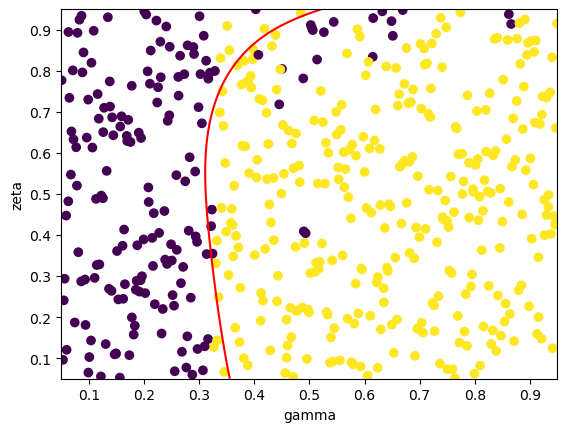

In [4]:
# CAS CLARINETTE

#gmin = 1/3
#gmax = 0.5
#zmin = 0.2
#zmax = 0.6

gmin = 0.05
gmax = 0.95
zmin = 0.05
zmax = 0.95


gammas = np.linspace(gmin,gmax,50)
zetas = np.linspace(zmin,zmax,50)
#Ls = np.array([]) # axe L discrétisé. Les L sont calculés en fonction des fréquence de jeu intentionnées

n_sim = 500 # 20 points de départ

#définissons les 20 premiers échantillons avec un carré latin :

sampler = qmc.LatinHypercube(d=2) #Méthode des carrés latins, résultats entre 0 et 1 exclus.
sample = sampler.random(n=n_sim)
g_width = gmax-gmin
z_width = zmax-zmin
sample[:,0] *= g_width
sample[:,0] += gmin
sample[:,1] *= z_width
sample[:,1] += zmin
data = sample

labels = np.zeros(n_sim)

for s in range(n_sim): #Calcul des labels
    g = sample[s,0]
    z = sample[s,1]
    Zc = z*P_M/U_A
    P = simulation(T_sec, delta_t, g, z, L, P_M, Zc)
    labels[s] = D_epsilon1(P) # CHOIX DU DESCRIPTEUR ICI POUR FIXER LES LABELS ETUDIES.

print(labels)

SVCl = sklearn.svm.SVC(gamma='auto')
clf = make_pipeline(StandardScaler(), SVCl)
clf.fit(data, labels)
plt.scatter(data[:,0], data[:,1], c=labels)
xx, yy = np.meshgrid(
    np.linspace(gmin, gmax, 500),
    np.linspace(zmin, zmax, 500)
)
plt.xlabel("gamma")
plt.ylabel("zeta")

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0], colors="r")#le plan trouvé par le SVM en rouge : là où la fonction de décision (dist point / hyperplan) vaut 0
plt.show()

In [36]:
# Justesse via la classifieur justesse:

[ 1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.
  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1.  1. -1.  1.  1.  1.  1.
  1. -1. -1. -1.  1.  1.  1. -1. -1. -1. -1.  1.  1.  1. -1.  1.  1.  1.
 -1. -1.  1. -1.  1. -1.  1.  1.  1. -1. -1. -1. -1. -1.  1.  1.  1. -1.
 -1. -1.  1.  1.  1.  1.  1. -1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1.
 -1. -1. -1.  1. -1.  1.  1. -1. -1.  1. -1.  1. -1. -1. -1.  1. -1. -1.
  1. -1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1.  1. -1. -1.  1. -1.  1.
  1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1. -1. -1.  1. -1.  1. -1.  1.
 -1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1. -1. -1.  1. -1. -1.
  1. -1.  1.  1. -1.  1.  1. -1.  1. -1.  1.  1. -1.  1. -1.  1.  1.  1.
  1.  1.  1.  1. -1.  1. -1. -1. -1.  1. -1. -1. -1.  1. -1.  1. -1. -1.
 -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.  1.  1.  1.  1. -1.  1.  1. -1.
  1. -1. -1. -1.  1.  1.  1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1.  1.
  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1. -1.  1

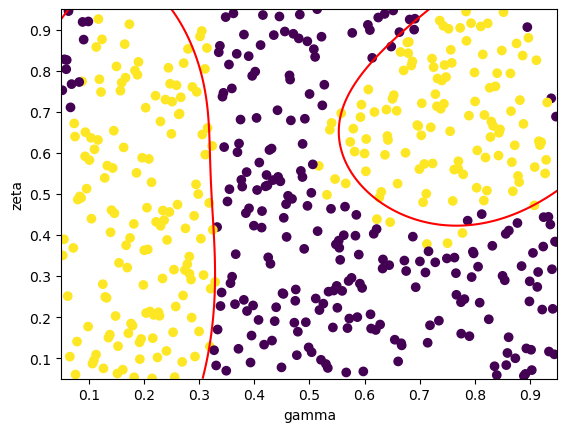

In [19]:
# CAS CLARINETTE

#gmin = 1/3
#gmax = 0.5
#zmin = 0.2
#zmax = 0.6

gmin = 0.05
gmax = 0.95
zmin = 0.05
zmax = 0.95


gammas = np.linspace(gmin,gmax,50)
zetas = np.linspace(zmin,zmax,50)
#Ls = np.array([]) # axe L discrétisé. Les L sont calculés en fonction des fréquence de jeu intentionnées

n_sim = 500 # 20 points de départ

#définissons les 20 premiers échantillons avec un carré latin :

sampler = qmc.LatinHypercube(d=2) #Méthode des carrés latins, résultats entre 0 et 1 exclus.
sample = sampler.random(n=n_sim)
g_width = gmax-gmin
z_width = zmax-zmin
sample[:,0] *= g_width
sample[:,0] += gmin
sample[:,1] *= z_width
sample[:,1] += zmin
data = sample

labels = np.zeros(n_sim)


clf_j = Classifier_justesse(f_ref=147.8, eps3=10, delta_t=1/(44100*2))

for s in range(n_sim): # Calcul des labels
    g = sample[s,0]
    z = sample[s,1]
    Zc = z * P_M / U_A
    
    # Appel de la simulation
    P = simulation(T_sec, delta_t, g, z, L, P_M, Zc)
    

    labels[s] = clf_j.classifieur_justesse(P)
    #labels[s] = D_ecart_freq(P,L) # CHOIX DU DESCRIPTEUR ICI POUR FIXER LES LABELS ETUDIES.

print(labels)

SVCl = sklearn.svm.SVC(gamma='auto')
clf = make_pipeline(StandardScaler(), SVCl)
clf.fit(data, labels)
plt.scatter(data[:,0], data[:,1], c=labels)
xx, yy = np.meshgrid(
    np.linspace(gmin, gmax, 500),
    np.linspace(zmin, zmax, 500)
)
plt.xlabel("gamma")
plt.ylabel("zeta")

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0], colors="r")#le plan trouvé par le SVM en rouge : là où la fonction de décision (dist point / hyperplan) vaut 0
plt.show()

# Doublement / Triplement de période:

In [37]:
# Avec le classifieur en temporel:

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.
  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.
  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

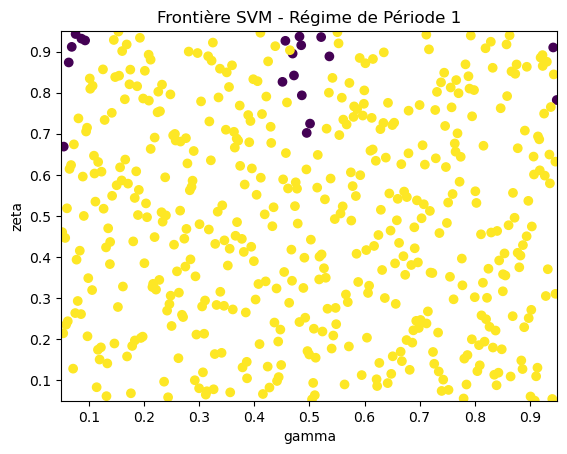

In [40]:
gmin = 0.05
gmax = 0.95
zmin = 0.05
zmax = 0.95

n_sim = 500 

sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(n=n_sim)
g_width = gmax-gmin
z_width = zmax-zmin
sample[:,0] *= g_width
sample[:,0] += gmin
sample[:,1] *= z_width
sample[:,1] += zmin
data = sample

labels = np.zeros(n_sim)

# régime cible:
CIBLE = 1

for s in range(n_sim):
    g = sample[s,0]
    z = sample[s,1]
    Zc = z * P_M / U_A
    P = simulation(T_sec, delta_t, g, z, L, P_M, Zc)
    
    regime = descripteur_multiplication_periode(P, 1/delta_t, 147.8)
    labels[s] = 1 if regime == CIBLE else -1

print(labels)

SVCl = sklearn.svm.SVC(gamma='auto')
clf = make_pipeline(StandardScaler(), SVCl)
clf.fit(data, labels)

plt.scatter(data[:,0], data[:,1], c=labels)
xx, yy = np.meshgrid(
    np.linspace(gmin, gmax, 500),
    np.linspace(zmin, zmax, 500)
)
plt.xlabel("gamma")
plt.ylabel("zeta")

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0], colors="r") 
plt.title(f"Frontière SVM - Régime de Période {CIBLE}")
plt.show()

# Autre classifieur justesse servant de bail de régime

In [38]:
# Avec le deuxième classifieur de régime basé sur le classifieur écart_freq écrit par Baptiste

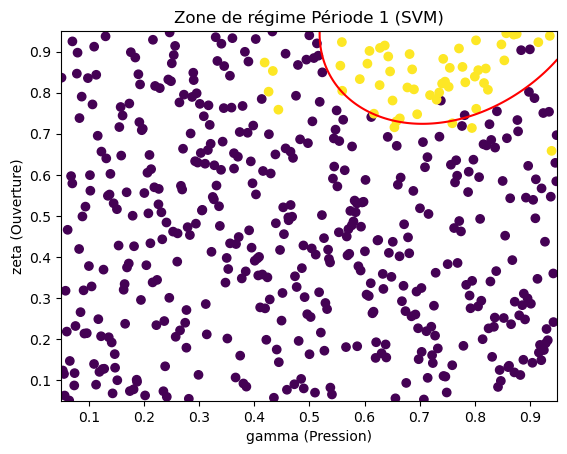

In [39]:
f_theorique = c / (4 * (L + 0.6133 * a))
REGIME_CIBLE = 1 # 1, 2 ou 3 du coup

labels = np.zeros(n_sim)

for s in range(n_sim):
    g = sample[s,0]
    z = sample[s,1]
    Zc = z * P_M / U_A
    
    P = simulation(T_sec, delta_t, g, z, L, P_M, Zc)
    regime = descripteur_regime_par_pitch(P, L, f_theorique, delta_t)
    labels[s] = 1 if regime == REGIME_CIBLE else -1

SVCl = sklearn.svm.SVC(gamma='auto')
clf = make_pipeline(StandardScaler(), SVCl)

if len(np.unique(labels)) > 1:
    clf.fit(data, labels)
    
    plt.scatter(data[:,0], data[:,1], c=labels)
    
    xx, yy = np.meshgrid(np.linspace(gmin, gmax, 500), np.linspace(zmin, zmax, 500))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contour(xx, yy, Z, levels=[0], colors="r")
    plt.xlabel("gamma (Pression)")
    plt.ylabel("zeta (Ouverture)")
    plt.title(f"Zone de régime Période {REGIME_CIBLE} (SVM)")
    plt.show()
else:
    print(f"Le régime {REGIME_CIBLE} n'a pas été trouvé dans l'échantillonnage.") 
    # vu que c'est arrivé bcp de fois, si tous les labels sont les mêmes, ça sert à rien de plot (de toute façon ça renverrai une erreur)
    # mais du coup, le code marche que pour le régime 1, mais est suffisamment précis pour isoler les régimes particuliers

# Section IV : Algorithme des SVM avec affinage

In [10]:
#Partie refinement, méthode avec grille

n_ref = 50
n_pos = 100

#contours :
xmin = min(data[:,0])
xmax = max(data[:,0])
ymin = min(data[:,1])
ymax = max(data[:,1])

x_pos = np.linspace(xmin, xmax, n_pos)
y_pos = np.linspace(ymin, ymax, n_pos)

def coord(i,j):
    return np.array([x_pos[i], y_pos[j]])

clf_grid = np.zeros((n_pos, n_pos)) #stocke les valeurs du svc sur la grille. permet donc de trouver les (quasi) zéros considérés pour ensuite calculer notre point de refinement
for i in range(n_pos):
    for j in range(n_pos):
        clf_grid[i,j] = clf.decision_function([coord(i,j)])[0]

dist_nearest_grid = np.zeros((n_pos, n_pos))
for i in range(n_pos):
    for j in range(n_pos):
        dist_nearest_grid[i,j] = np.min(np.sum((coord(i,j)-data)**2, axis=1))

seuil_tol = 10**(-2)
#print(np.sum(np.abs(clf_grid) < seuil_tol)) on en compte 20 par exemple ici, donc c'est pas trop mal. On choisit parmi les 20 lequel a une plus grande val de dist_nearest


for step in tqdm(range(0,n_ref)):
    clf_zeros_mask = np.abs(clf_grid) < seuil_tol
    ijs = np.where(clf_zeros_mask) #indices dans la matrice npos*npos où on a nos quasi-zéros
    #n_zeros = len(ijs[0])
    #print(n_zeros)
    argm = np.argmax(dist_nearest_grid[clf_zeros_mask]) #l'argmax retrouvé est celui de la version flat de la matrice, qui est de dim n_zeros*n_zeros
    #print(dist_nearest_grid[clf_zeros_mask].shape)
    i = ijs[0][argm]
    j = ijs[1][argm]
    x_r = coord(i,j)
    data = np.concatenate((data, [x_r]), axis=0)
    labels = np.concatenate((labels, [D_epsilon1(simulation(T_sec, delta_t, x_r[0], x_r[1], L, P_M, Zc))]), axis=0)
    clf.fit(data, labels)
    #mise à jour des grilles :
    for i in range(n_pos):
        for j in range(n_pos):
            dist_nearest_grid[i,j] = min(dist_nearest_grid[i,j], np.sum((coord(i,j)-x_r)**2))
            #soit le point le plus proche l'est tjrs, soit c'est le nouveau point x_r. on prend donc le min des dist.
            clf_grid[i,j] = clf.decision_function([coord(i,j)])[0]
            #pas de raccourci pou l'update de celui-la malheureusement, il faut tout recalculer.

100%|██████████| 50/50 [07:25<00:00,  8.91s/it]


#Section V : Cartographie finale

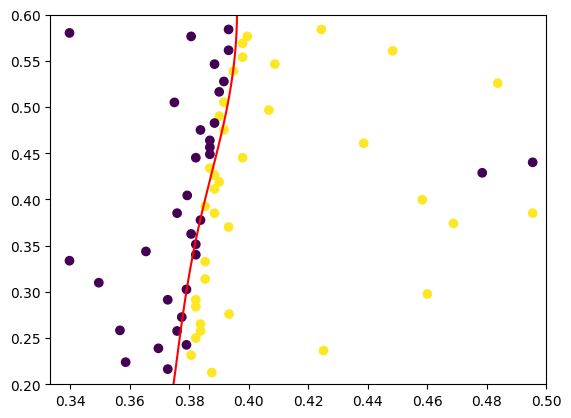

In [11]:
plt.scatter(data[:,0], data[:,1], c=labels)
xx, yy = np.meshgrid(
    np.linspace(gmin, gmax, 500),
    np.linspace(zmin, zmax, 500)
)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0], colors="r")#le plan trouvé par le SVM en rouge : là où la fonction de décision (dist point / hyperplan) vaut 0
plt.show()